# Lab 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atsuyaourt/gis-python-tutorial/blob/main/book/lab001.ipynb)

In [7]:
%%capture
import sys
from pathlib import Path

DATA_DIR = Path("../data")
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    !git clone https://github.com/atsuyaourt/gis-python-tutorial.git
    !pip install salem cartopy contextily
    DATA_DIR = Path("gis-python-tutorial/data")

In [8]:
import gzip
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import salem

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import contextily as cx
from shapely.geometry import LineString

## Tropical Cyclone Track

We’ll work with historical track data for Tropical Storm Trami. We’ll begin by loading this data from a CSV file into a pandas DataFrame to familiarize ourselves with its structure and basic properties.

In [12]:
input_csv = DATA_DIR / "csv/wp222024_track.csv"

track_df = "open input_csv using pandas"
track_df.head()

The `timestamp` column in our dataset currently contains date and time information in string format. We can convert this column to `datetime` format, which will help streamline any further analysis involving time.

In [ ]:
track_df.dtypes

In [11]:
track_df.timestamp = "convert timestamp column to datetime"

<div class="alert alert-block alert-success">
    <b>Guide Questions:</b>
    <ol>
        <li><b>Maximum Intensity:</b> What is the highest intensity recorded for TC Trami during its track?</li>
        <li><b>Final Location and Intensity:</b> Where was TC Trami located during its final recorded entry, and what was its intensity at that time?</li>
        <li><b>Average Translational Speed:</b> Calculate the average translational speed of TC Trami.</li>
        <li><b>Duration and Lifecycle:</b> How long did TC Trami exist according to the dataset?</li>
    <ol>
</div>

In this step, we’ll convert our pandas `DataFrame` into a `GeoDataFrame`, which will allow us to leverage spatial operations and analysis with geopandas. We'll use the lon and lat columns to create a geometric representation of each track point, which will serve as the foundation for visualizing and analyzing the storm's path. The `EPSG:4326` coordinate reference system [(WGS 84)](https://en.wikipedia.org/wiki/World_Geodetic_System) is applied, which is suitable for geographic coordinates.

In [20]:
wgs84_crs = "EPSG:4326"
track_pt = "use geopandas to create a geodataframe from the lat, lon columns"
track_pt.head()

,timestamp,lat,lon,intensity,geometry
0,2024-10-29 12:00:00+00:00,16.7,109.5,15,POINT (109.5 16.7)
1,2024-10-29 06:00:00+00:00,16.6,109.3,15,POINT (109.3 16.6)
2,2024-10-29 00:00:00+00:00,16.6,108.8,20,POINT (108.8 16.6)
3,2024-10-28 18:00:00+00:00,16.4,108.7,25,POINT (108.7 16.4)
4,2024-10-28 12:00:00+00:00,16.0,108.6,25,POINT (108.6 16)


Now that we have created a `GeoDataFrame` for our TC track points, we can plot them on a map to visualize its path.

This initial plot provides a basic geographic overview of the storm track, setting the foundation for deeper analysis of the storm’s characteristics.

<GeoAxes: >

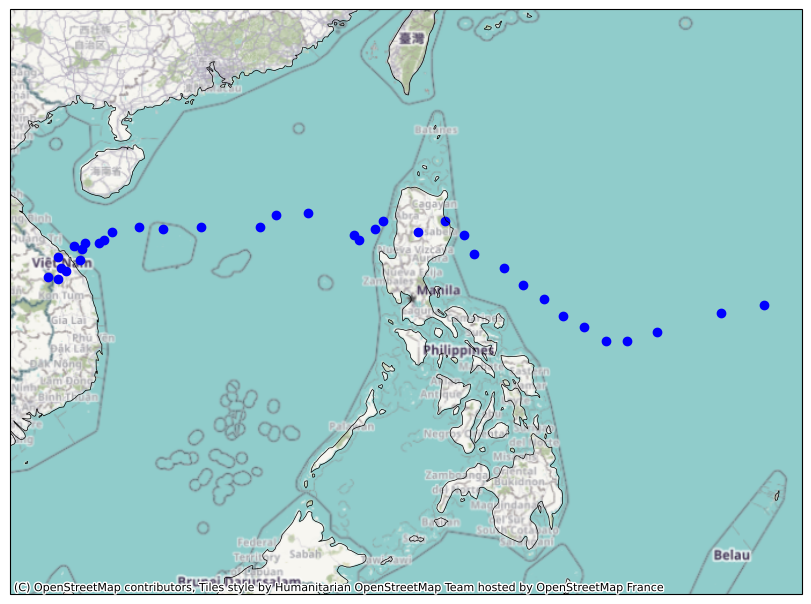

In [26]:
min_lon, max_lon = 106.0, 135.5
min_lat, max_lat = 4.0, 25.0

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True, subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.coastlines(lw=0.5)

cx.add_basemap(ax, crs=track_pt.crs)

track_pt.plot(ax=ax, color="blue")

To gain insights into the cyclone's strength over time, we’ll categorize each point in the track data using the [Saffir-Simpson Hurricane Wind Scale](https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale). This scale classifies cyclones based on their wind speed in knots into different categories, from a tropical depression to Category 5.

We define a function, `cyclone_category`, which takes in the wind speed and returns a category index based on the Saffir-Simpson scale. We add a new column to our `track_pt` GeoDataFrame for the category and a corresponding column for the category name.

In [21]:
TC_CAT_NAME = ("TD", "TS", "1", "2", "3", "4", "5")

def cyclone_category(ws: float) -> int:
    """
    Categorize a cyclone based on wind speed in knots using the Saffir-Simpson scale.
    
    Parameters:
    ws (float): Wind speed in knots.
    
    Returns:
    int: Index of the TC category.
    """
    if ws <= 33:
        return 0
    elif ws <= 63:
        return 1
    elif ws <= 82:
        return 2
    elif ws <= 95:
        return 3
    elif ws <= 112:
        return 4
    elif ws <= 136:
        return 5
    elif ws >= 137:
        return 6
    else:
        return -1

In [22]:
track_pt["cat"] = "new column for the TC category index"
track_pt["cat_name"] = "new column for the TC category name"

Let's create a continuous line representing the path of Tropical Storm Trami using a `LineString` object from the Shapely library. This line connects each point in the storm’s track, allowing us to visualize its path as a single line instead of individual points.

In [23]:
track_ln = "LineString object representing the TC path"

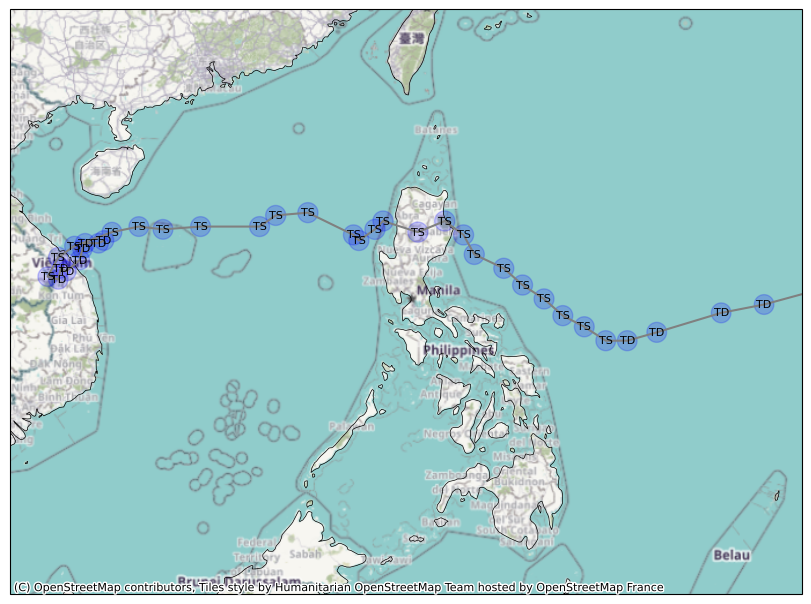

In [27]:
min_lon, max_lon = 106.0, 135.5
min_lat, max_lat = 4.0, 25.0

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True, subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.coastlines(lw=0.5)

cx.add_basemap(ax, crs=track_pt.crs)

wgs84_crs = 'EPSG:4326'
utm_crs = track_pt.estimate_utm_crs()  # Automatically suggests the UTM zone

track_utm_pt = track_pt.to_crs(utm_crs)
track_buf_pt = track_utm_pt.buffer(40_000).to_crs(wgs84_crs)

track_buf_pt.plot(ax=ax, edgecolor="blue", facecolor="blue", alpha=0.2)
track_ln.plot(ax=ax, color='gray')

# Add labels at the center of each geometry based on a column
track_utm2_pt = track_pt.cx[min_lon:max_lon, min_lat:max_lat].to_crs(utm_crs)
for c, label in zip(track_utm2_pt.geometry.centroid, track_utm2_pt['cat_name']):
    cc = gpd.GeoDataFrame(geometry=[c], crs=utm_crs).to_crs(wgs84_crs)
    ax.text(cc.geometry[0].x, cc.geometry[0].y, str(label), fontsize=8, ha='center', va='center', color="black")

## Gridded Rainfall

In this section, we will load the preprocessed hourly rainfall data from the Global Satellite Mapping of Precipitation [(GSMaP)](https://sharaku.eorc.jaxa.jp/GSMaP/index.htm) for October 21-23, 2024. The GSMaP dataset provides crucial information for understanding rainfall patterns and monitoring precipitation events globally.

In [5]:
nc_file = DATA_DIR / "gsmap/gsmap_2024-10-21_00.nc"

gsmap_ds = "open the gridded file using xarray"
gsmap_ds

<xarray.Dataset> Size: 7MB
Dimensions:  (lat: 162, lon: 140, time: 73)
Coordinates:
  * lat      (lat) float64 1kB 4.85 4.95 5.05 5.15 ... 20.65 20.75 20.85 20.95
  * lon      (lon) float64 1kB 115.0 115.1 115.2 115.3 ... 128.8 128.8 128.9
  * time     (time) datetime64[ns] 584B 2024-10-21 ... 2024-10-24
Data variables:
    precip   (time, lat, lon) float32 7MB ...
Attributes:
    Conventions:  CF-1.7
    source:       gsmap_gauge

<div class="alert alert-block alert-success">
    <b>Guide Questions:</b>
    <ol>
        <li><b>Temporal Analysis:</b> How does the rainfall intensity vary across different hours of the day on Bicol?</li>
        <li><b>Rainfall Extremes:</b> What are the maximum and minimum rainfall values recorded in this dataset?</li>
    <ol>
</div>

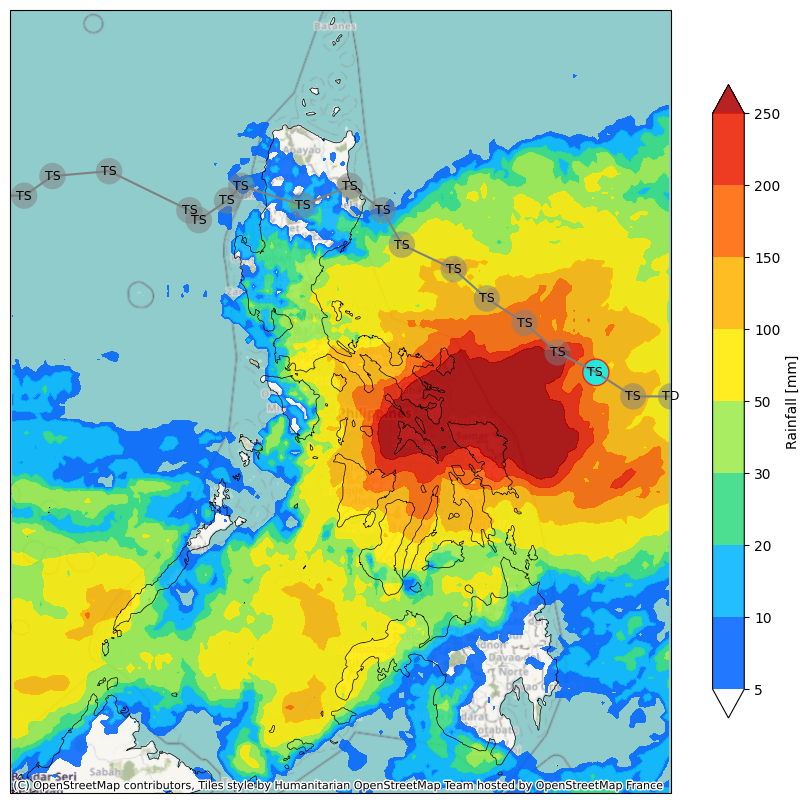

In [25]:
# import seaborn as sns

# levels = range(0, 500, 50)
# colors = sns.color_palette('Blues', n_colors=len(levels)+1)
# colors = [c+"00" for c in colors.as_hex()[:3]] + [c+"ee" for c in colors.as_hex()[3:]]

levels = [5, 10, 20, 30, 50, 100, 150, 200, 250]
colors = [
    "#0064ff",
    "#01b4ff",
    "#32db80",
    "#9beb4a",
    "#ffeb00",
    "#ffb302",
    "#ff6400",
    "#eb1e00",
    "#af0000",
]
colors = ["#ffffff00"] + [c+"dd" for c in colors]

min_lon, max_lon = 115.0, 129.0
min_lat, max_lat = 5.0, 21.0

min_ts, max_ts = '2024-10-21', '2024-10-22'
dts = pd.date_range(min_ts, max_ts, freq='h', inclusive='right', tz='UTC').tz_convert(None)

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True, subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.coastlines(lw=0.5)
cx.add_basemap(ax, crs=track_pt.crs)

wgs84_crs = 'EPSG:4326'
utm_crs = track_pt.estimate_utm_crs()  # Automatically suggests the UTM zone

gsmap_ds.sel(time=dts).precip.sum(dim='time').plot.contourf(ax=ax, colors=colors, levels=levels, cbar_kwargs={'label': 'Rainfall [mm]', 'shrink': 0.8, 'extend': 'both'})

track2_pt = track_pt.cx[min_lon:max_lon, min_lat:max_lat]
track2_utm_pt = track2_pt.to_crs(utm_crs)
track2_buf_pt = track2_utm_pt.buffer(30_000).to_crs(wgs84_crs)
track2_buf_pt.plot(ax=ax, edgecolor="none", facecolor="gray", alpha=0.5)
track2_buf_pt[track2_pt.timestamp == max_ts].plot(ax=ax, edgecolor="red", facecolor="cyan", alpha=0.8)
track_ln.plot(ax=ax, color='gray')

# Add labels at the center of each geometry based on a column
for c, label in zip(track2_utm_pt.geometry.centroid, track2_utm_pt['cat_name']):
    cc = gpd.GeoDataFrame(geometry=[c], crs=utm_crs).to_crs(wgs84_crs)
    ax.text(cc.geometry[0].x, cc.geometry[0].y, str(label), fontsize=9, ha='center', va='center', color="black")

## Affected Areas

In this step, we load geographical boundary data for municipalities in the Philippines from a shapefile. The dataset, `ph_muni`, contains polygon boundaries for each municipality across the country.

In [6]:
ph_shp = DATA_DIR / "basemap/ph/adm2/PHL_adm2.shp"

ph_muni = "open ph_shp using geopandas"
ph_muni.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,179,PHL,Philippines,1,Abra,1,Bangued,PH.AB.BN,0,140101,Bayan|Munisipyo,Municipality,None,None,"POLYGON ((120.61553 17.6236, 120.6187 17.62331..."
1,179,PHL,Philippines,1,Abra,2,Boliney,PH.AB.BL,0,140102,Bayan|Munisipyo,Municipality,None,None,"POLYGON ((120.90749 17.41933, 120.92464 17.413..."
2,179,PHL,Philippines,1,Abra,3,Bucay,PH.AB.BU,0,140103,Bayan|Munisipyo,Municipality,None,None,"POLYGON ((120.74548 17.57671, 120.75101 17.575..."
3,179,PHL,Philippines,1,Abra,4,Bucloc,PH.AB.BC,0,140104,Bayan|Munisipyo,Municipality,None,None,"POLYGON ((120.82477 17.41721, 120.78956 17.416..."
4,179,PHL,Philippines,1,Abra,5,Daguioman,PH.AB.DG,0,140105,Bayan|Munisipyo,Municipality,None,None,"POLYGON ((120.98141 17.50534, 120.98367 17.504..."


However, for our analysis, we are interested only in provincial boundaries.

In [51]:
ph_prov = "generate provincial boundaries from ph_muni"
ph_prov.head()

,NAME_1,geometry,ID_0,ISO,NAME_0,ID_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2
0,Abra,"POLYGON ((120.68198 17.25612, 120.68122 17.256...",179,PHL,Philippines,1,1,Bangued,PH.AB.BN,0,140101,Bayan|Munisipyo,Municipality,None,Licuan
1,Agusan del Norte,"POLYGON ((125.66019 8.76121, 125.66515 8.74586...",179,PHL,Philippines,2,28,Buenavista,PH.AN.BE,0,160201,Bayan|Munisipyo,Municipality,None,None
2,Agusan del Sur,"POLYGON ((125.98082 7.99822, 125.97065 7.99832...",179,PHL,Philippines,3,41,Bayugan City,PH.AS.BY,0,160301,Lungsod|Siyudad,City,None,None
3,Aklan,"MULTIPOLYGON (((122.34997 11.43417, 122.34952 ...",179,PHL,Philippines,4,55,Altavas,PH.AK.AT,0,60401,Bayan|Munisipyo,Municipality,None,None
4,Albay,"MULTIPOLYGON (((123.59427 13.02025, 123.59004 ...",179,PHL,Philippines,5,72,Bacacay,PH.AL.BC,0,50501,Bayan|Munisipyo,Municipality,None,Locsin


### Proximity to Tropical Cyclone

To identify provinces affected by the tropical cyclone’s (TC) proximity, we focus on those within a 400 km radius of the current TC position.

In [ ]:
ts = '2024-10-22'
roi = 400_000

tc_pt = "pt in tc_track with timestamp == ts"
tc_roi = "create a 400km buffer"

In [ ]:
min_lon, max_lon = 115.0, 129.0
min_lat, max_lat = 5.0, 21.0

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True, subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.coastlines(lw=0.5)
cx.add_basemap(ax, crs=track_pt.crs)

tc_roi.plot(ax=ax)
ph_prov.plot(ax=ax, facecolor="none")

We use a spatial query to find provinces whose boundaries intersect with the 400 km buffer, identifying the areas within the cyclone's potential impact zone. These provinces are plotted in red.

In [ ]:
ph_prov_within_radius = "provinces within the 400km buffer"

<GeoAxes: >

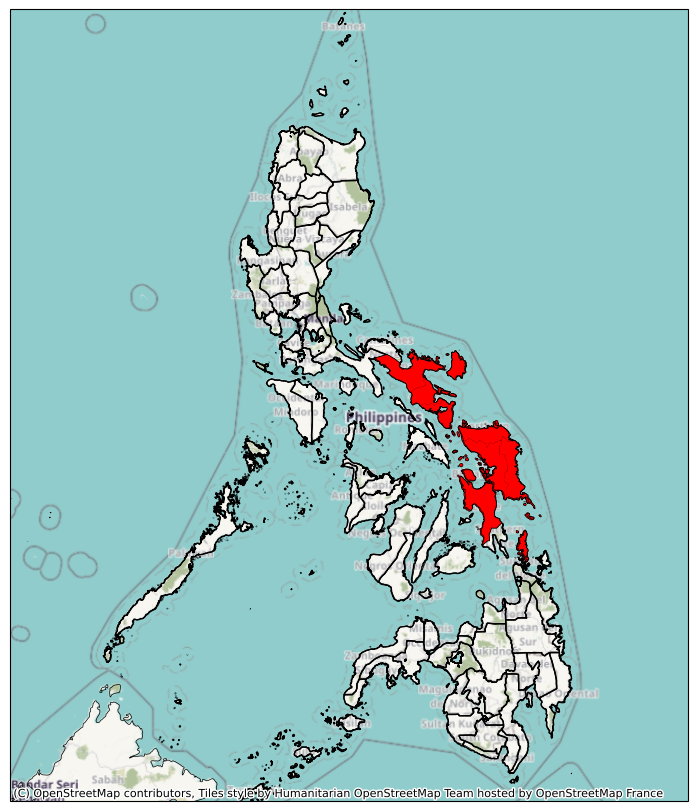

In [53]:
min_lon, max_lon = 115.0, 129.0
min_lat, max_lat = 5.0, 21.0

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True, subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.coastlines(lw=0.5)
cx.add_basemap(ax, crs=track_pt.crs)

ph_prov.plot(ax=ax, facecolor="none")
ph_prov_within_radius.plot(ax=ax, color="red")

### Rainfall

To analyze the provinces potentially impacted by heavy rainfall due to the tropical cyclone, we examine the accumulated rainfall over a one-day period.

In [ ]:
min_ts, max_ts = '2024-10-21', '2024-10-22'
dts = pd.date_range(min_ts, max_ts, freq='h', inclusive='right', tz='UTC').tz_convert(None)

rain_1day = "1 day accumulated rainfall"

<GeoAxes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

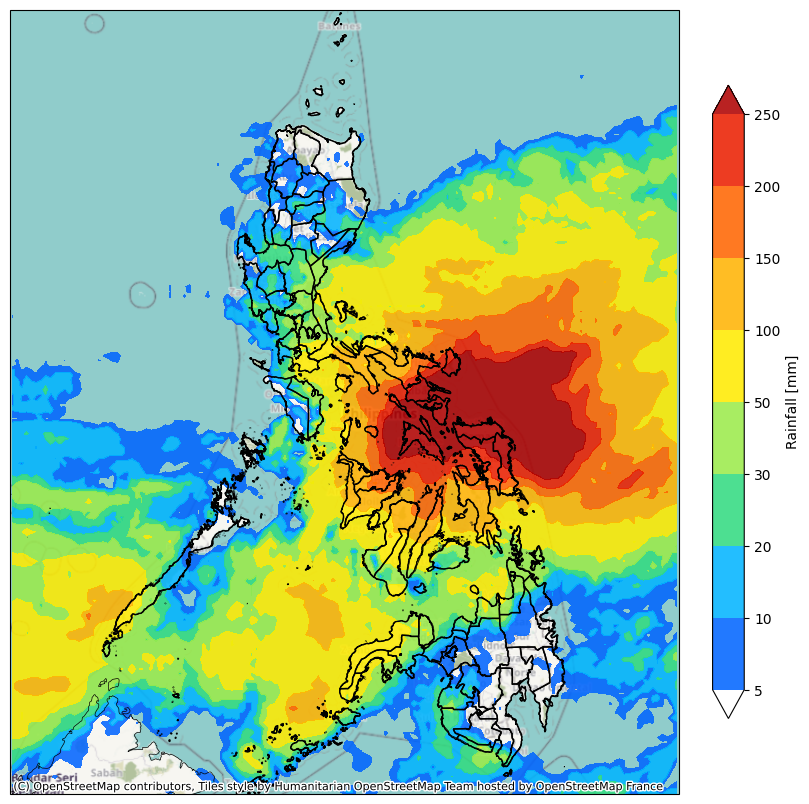

In [42]:
min_lon, max_lon = 115.0, 129.0
min_lat, max_lat = 5.0, 21.0

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True, subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.coastlines(lw=0.5)
cx.add_basemap(ax, crs=track_pt.crs)

rain_1day.plot.contourf(ax=ax, colors=colors, levels=levels, cbar_kwargs={'label': 'Rainfall [mm]', 'shrink': 0.8, 'extend': 'both'})
ph_prov.plot(ax=ax, facecolor="none")

We first compute the daily maximum rainfall for each province. 

In [55]:
from tqdm.notebook import tqdm

ph_prov_rain = [dict(name=i, rain=rain_1day.salem.roi(shape=ph_prov[ph_prov.index ==  i]).max().values) for i, r in tqdm(ph_prov.iterrows(), total=ph_prov.shape[0], desc="Compute max rain")]
ph_prov_rain = pd.DataFrame(ph_prov_rain)
ph_prov = ph_prov.merge(ph_prov_rain, left_index=True, right_on='name', how='left')
ph_prov.head()

Compute max rain:   0%|          | 0/81 [00:00<?, ?it/s]

,NAME_1,geometry,ID_0,ISO,NAME_0,ID_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,name,rain
0,Abra,"POLYGON ((120.68198 17.25612, 120.68122 17.256...",179,PHL,Philippines,1,1,Bangued,PH.AB.BN,0,140101,Bayan|Munisipyo,Municipality,None,Licuan,0,15.912243
1,Agusan del Norte,"POLYGON ((125.66019 8.76121, 125.66515 8.74586...",179,PHL,Philippines,2,28,Buenavista,PH.AN.BE,0,160201,Bayan|Munisipyo,Municipality,None,None,1,56.948498
2,Agusan del Sur,"POLYGON ((125.98082 7.99822, 125.97065 7.99832...",179,PHL,Philippines,3,41,Bayugan City,PH.AS.BY,0,160301,Lungsod|Siyudad,City,None,None,2,43.931633
3,Aklan,"MULTIPOLYGON (((122.34997 11.43417, 122.34952 ...",179,PHL,Philippines,4,55,Altavas,PH.AK.AT,0,60401,Bayan|Munisipyo,Municipality,None,None,3,151.4874
4,Albay,"MULTIPOLYGON (((123.59427 13.02025, 123.59004 ...",179,PHL,Philippines,5,72,Bacacay,PH.AL.BC,0,50501,Bayan|Munisipyo,Municipality,None,Locsin,4,359.8385


To highlight provinces that have experienced substantial rainfall, we filter `ph_prov` to show only those provinces with maximum rainfall values exceeding *200 mm*. These provinces are plotted in red on the map, allowing us to quickly identify the areas at greater risk of flooding or other rain-induced impacts.

In [ ]:
ph_prov_with_high_rain = "provinces with rainfall above 200 mm"

<GeoAxes: >

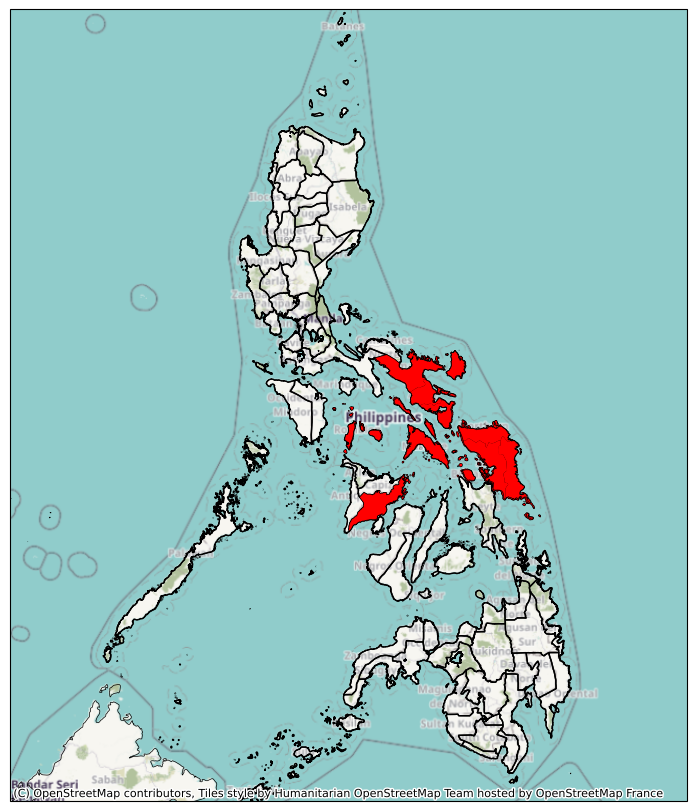

In [56]:
min_lon, max_lon = 115.0, 129.0
min_lat, max_lat = 5.0, 21.0

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True, subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.coastlines(lw=0.5)
cx.add_basemap(ax, crs=track_pt.crs)

ph_prov.plot(ax=ax, facecolor="none")
ph_prov_with_high_rain.plot(ax=ax, color="red")

<div class="alert alert-block alert-success">
    <b>Guide Questions:</b>
    <ol>
        <li><b>Proximity to the Tropical Cyclone:</b> Which provinces are located within a 400 km radius of the tropical cyclone's (TC) current position?</li>
        <li><b>High Rainfall Intensity:</b> Which provinces experienced rainfall levels of 200 mm or more over the past day?</li>
        <li><b>Comparative Impact Analysis:</b> Are there provinces within the 400 km radius that received less than 200 mm of rainfall? Conversely, are there provinces outside the 400 km radius that received more than 200 mm of rainfall?</li>
    <ol>
</div>